In [ ]:
#============================================================
# Generate chaotic Rössler system data
# Rows = x1..x7, y1..y7, z1..z7
# Columns = samples from perturbed initial conditions
#============================================================

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp

# ========================
# PARAMETERS
# ========================
num_samples = 2000      # number of samples (perturbed initial conditions)
T = 7                   # number of timepoints to save
t_total = 120           # total integration time
a, b, c = 0.2, 0.2, 5.7  # classic chaotic Rössler parameters
transient_time = 70     # discard first 20 units to avoid transients
t_eval = np.linspace(transient_time, t_total, T)  # 7 equidistant timepoints after transient

# ========================
# Base initial condition (chaotic regime)
# ========================
base_x0 = np.array([0.1, 0.0, 0.0])
perturb_scale = 1e-3  # small perturbation for samples

# ========================
# Rössler system
# ========================
def rossler(t, X):
    dx = -X[1] - X[2]
    dy = X[0] + a*X[1]
    dz = b + X[2]*(X[0] - c)
    return [dx, dy, dz]

# ========================
# Generate data
# ========================
data = np.zeros((3*T, num_samples))  # 21 rows (x1..x7, y1..y7, z1..z7), columns = samples

for s in range(num_samples):
    # Slightly perturb initial condition
    x0 = base_x0 + np.random.normal(0, perturb_scale, size=3)
    sol = solve_ivp(rossler, (0, t_total), x0, t_eval=t_eval,
                    rtol=1e-9, atol=1e-12)
    
    # Fill rows
    data[0:T, s] = sol.y[0, :]      # x1..x7
    data[T:2*T, s] = sol.y[1, :]    # y1..y7
    data[2*T:3*T, s] = sol.y[2, :]  # z1..z7

# ========================
# Save to CSV
# ========================
df = pd.DataFrame(data)
csv_file = "rossler_chaotic_data.csv"
df.to_csv(csv_file, index=False)

print(f"Rössler chaotic data saved to {csv_file}")
print("Data shape (rows x samples):", data.shape)


In [2]:
#============================================================
# DSRN for Rossler Chaotic Data Prediction
# Predict next timepoint from previous timepoint
#============================================================

import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr

# =====================================================
# LOAD chaotic data
# =====================================================
file = "rossler_chaotic_data.csv"
df = pd.read_csv(file)
expr = df.values       # shape (3*T, num_samples)

num_samples = expr.shape[1]
T = 7
num_genes = 3  # x, y, z

print("Loaded data:", expr.shape)
print("Variables:", num_genes, "Timepoints:", T, "Samples:", num_samples)

# =====================================================
# FORM INPUT → OUTPUT PAIRS FOR EACH VARIABLE
# X: t → t+1
# Y: next timepoint
# =====================================================
X = []
Y = []

for g in range(num_genes):
    block = expr[g*T:(g+1)*T, :]   # rows for this variable (T x num_samples)
    for t in range(T-1):
        X.append(block[t, :])
        Y.append(block[t+1, :])

X = np.array(X)   # shape ((T-1)*num_genes, num_samples)
Y = np.array(Y)

print("X shape:", X.shape)
print("Y shape:", Y.shape)

# =====================================================
# TRAIN / TEST SPLIT — 80% samples train, 20% test
# =====================================================
samples = np.arange(num_samples)
train_idx, test_idx = train_test_split(samples, test_size=0.2, random_state=42)

print("Train samples:", len(train_idx), "Test samples:", len(test_idx))

# =====================================================
# NORMALIZE
# =====================================================
scaler_in = StandardScaler()
scaler_out = StandardScaler()

X_norm = scaler_in.fit_transform(X.T).T       # (input_dim, samples)
Y_norm = scaler_out.fit_transform(Y.T).T      # (output_dim, samples)

M = X_norm.shape[0]   # input dimension
P = Y_norm.shape[0]   # output dimension
D = X_norm.shape[1]   # number of samples

print("Input dim:", M, "Output dim:", P, "Samples:", D)

# =====================================================
# RESERVOIR PARAMETERS
# =====================================================
N = 30   # number of Lorenz reservoirs
t_initial, t_final = 0, 30

# Random reservoir parameters
param_range_reservoir = [(9.9, 10.1), (27.9, 28.1), (2.65, 2.70)]
reservoir_params = np.array([
    [np.random.uniform(low, high) for low, high in param_range_reservoir] +
    [np.random.uniform(1, 8)]
    for _ in range(N)
])

# Random input matrix
R = np.random.uniform(-1, 1, size=(3*N, M))
print("R shape:", R.shape)

# =====================================================
# LORENZ SYSTEM FOR RESERVOIR
# =====================================================
def lorenz_system(t, X, params):
    X = X.reshape(N, 3)
    dxdt = params[:,0] * (X[:,1] - X[:,0]) / params[:,3]
    dydt = (X[:,0]*(params[:,1]-X[:,2]) - X[:,1]) / params[:,3]
    dzdt = (X[:,0]*X[:,1] - params[:,2]*X[:,2]) / params[:,3]
    return np.stack([dxdt, dydt, dzdt], axis=1).flatten()

# =====================================================
# RESERVOIR COMPUTATION
# =====================================================
phi = np.zeros((3*N, D))

for i in range(D):
    inp = R @ X_norm[:, i]
    sol = solve_ivp(
        lorenz_system, (t_initial, t_final), inp,
        t_eval=[t_final], args=(reservoir_params,),
        rtol=1e-6, atol=1e-9
    )
    phi[:, i] = sol.y[:, -1]

print("Reservoir state shape:", phi.shape)

# =====================================================
# TRAIN / TEST SPLIT RESERVOIR STATES
# =====================================================
phi_train = phi[:, train_idx].T
phi_test  = phi[:, test_idx].T

Y_train = Y_norm[:, train_idx].T
Y_test  = Y_norm[:, test_idx].T

# =====================================================
# LEAST SQUARES READOUT
# =====================================================
S_T, residuals, rank, svals = np.linalg.lstsq(phi_train, Y_train, rcond=None)
S = S_T.T   # shape (P, 3N)

# =====================================================
# PREDICT
# =====================================================
pred_train_norm = S @ phi[:, train_idx]
pred_test_norm  = S @ phi[:, test_idx]

pred_train = scaler_out.inverse_transform(pred_train_norm.T).T
pred_test  = scaler_out.inverse_transform(pred_test_norm.T).T

Y_train_true = Y[:, train_idx].astype(float)
Y_test_true  = Y[:, test_idx].astype(float)

# =====================================================
# METRICS
# =====================================================
mse_train = np.mean((pred_train - Y_train_true)**2)
mse_test  = np.mean((pred_test - Y_test_true)**2)

corr_train = pearsonr(pred_train.flatten(), Y_train_true.flatten())[0]
corr_test  = pearsonr(pred_test.flatten(), Y_test_true.flatten())[0]

print("\n===========================")
print("TRAIN MSE:", mse_train)
print("TEST  MSE:", mse_test)
print("TRAIN Corr:", corr_train)
print("TEST  Corr:", corr_test)
print("===========================\n")


Matplotlib is building the font cache; this may take a moment.


Loaded data: (21, 2000)
Variables: 3 Timepoints: 7 Samples: 2000
X shape: (18, 2000)
Y shape: (18, 2000)
Train samples: 1600 Test samples: 400
Input dim: 18 Output dim: 18 Samples: 2000
R shape: (90, 18)
Reservoir state shape: (90, 2000)

TRAIN MSE: 0.15323038983367723
TEST  MSE: 0.2126184662361104
TRAIN Corr: 0.9958690014946628
TEST  Corr: 0.9942640584273997



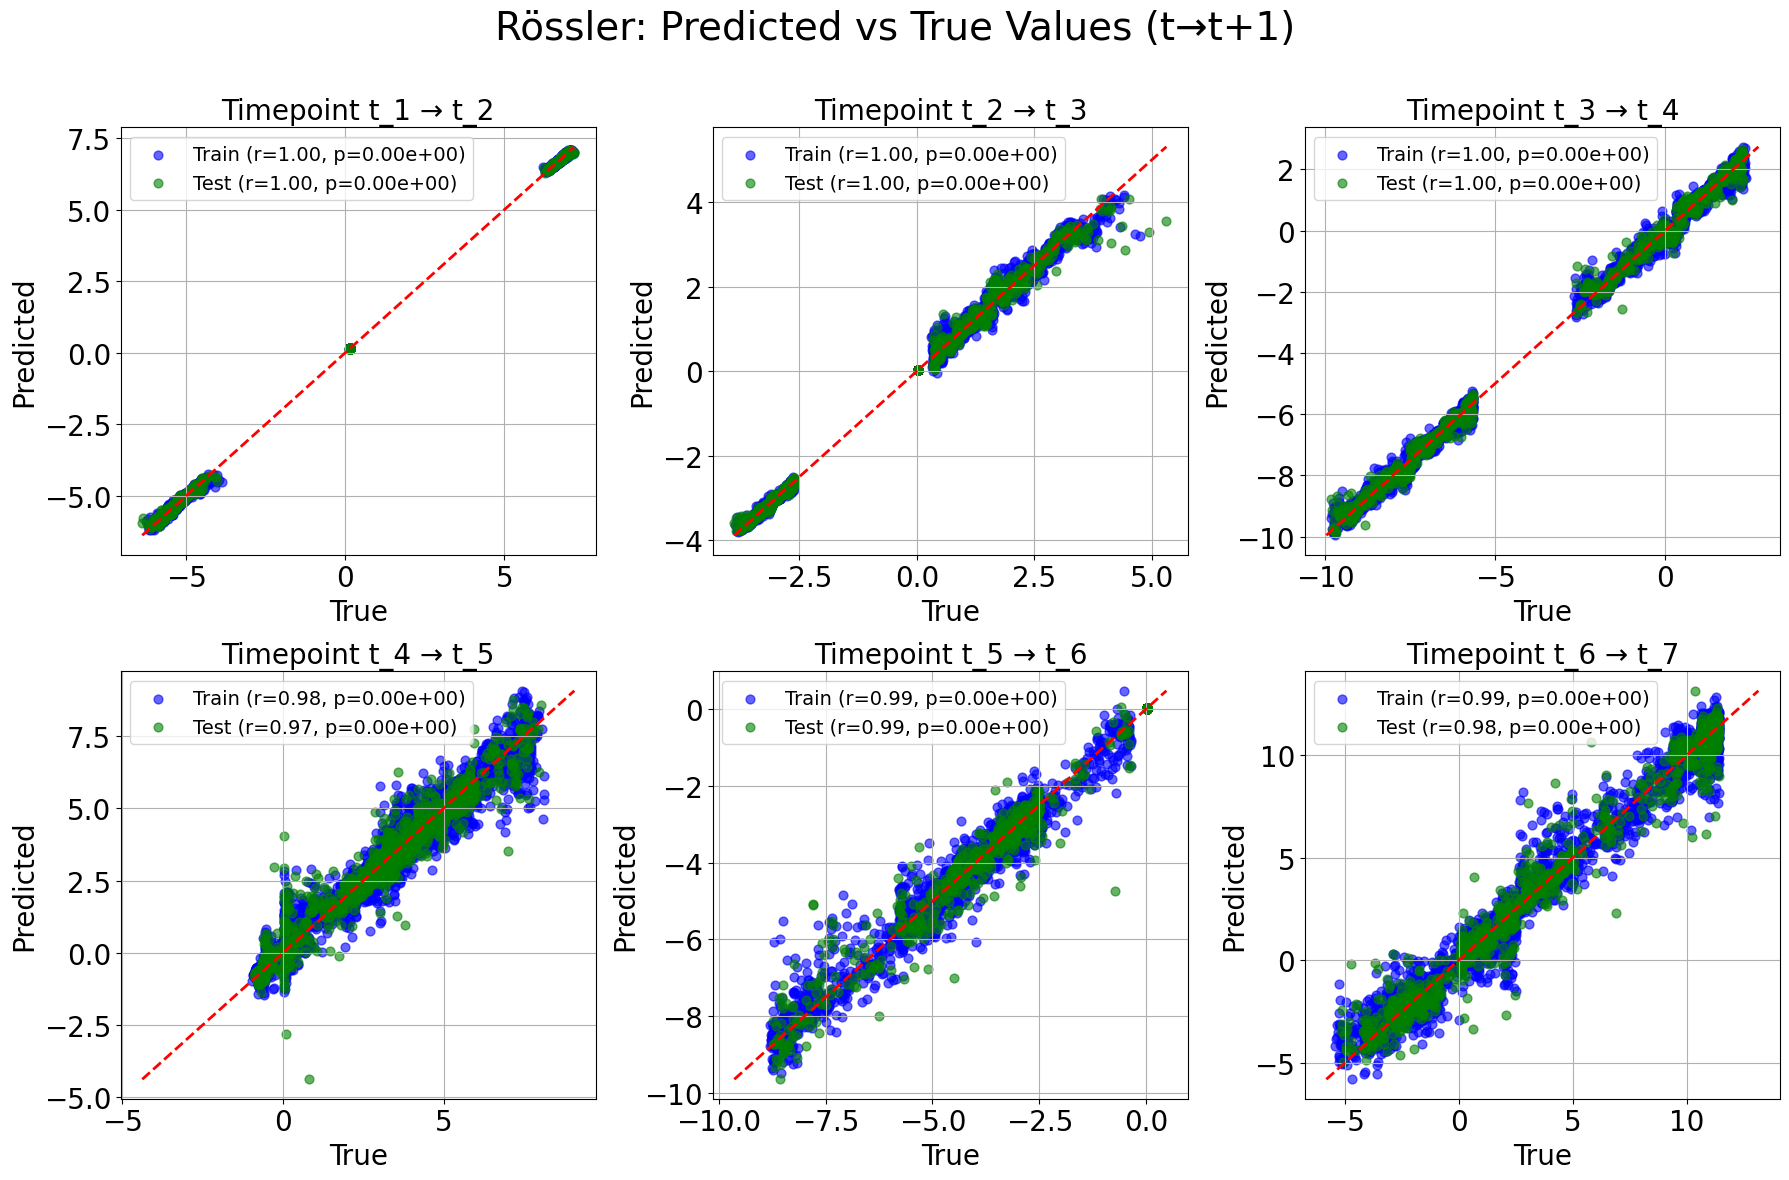

In [4]:
# ------------------------------------------------------------
# Plot train & test predictions across timepoints (t → t+1)
# ------------------------------------------------------------

num_timepoints = T - 1   # t1→t2, t2→t3, ...., t6→t7

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for t in range(num_timepoints):

    ax = axes[t]

    # Select rows corresponding to each timepoint transition t→t+1
    true_train = Y_train_true[t::num_timepoints, :]
    true_test  = Y_test_true[t::num_timepoints, :]

    pred_train_sub = pred_train[t::num_timepoints, :]
    pred_test_sub  = pred_test[t::num_timepoints, :]

    # ---- Compute correlation + p-values ----
    corr_train, p_train = pearsonr(true_train.flatten(),
                                   pred_train_sub.flatten())

    corr_test, p_test = pearsonr(true_test.flatten(),
                                 pred_test_sub.flatten())

    # ---- Plot ----
    ax.scatter(true_train.flatten(), pred_train_sub.flatten(),
               color='blue', alpha=0.6, s=40,
               label=f"Train (r={corr_train:.2f}, p={p_train:.2e})")

    ax.scatter(true_test.flatten(), pred_test_sub.flatten(),
               color='green', alpha=0.6, s=40,
               label=f"Test (r={corr_test:.2f}, p={p_test:.2e})")

    # ---- Diagonal identity line ----
    mn = min(true_train.min(), true_test.min(),
             pred_train_sub.min(), pred_test_sub.min())
    mx = max(true_train.max(), true_test.max(),
             pred_train_sub.max(), pred_test_sub.max())

    ax.plot([mn, mx], [mn, mx], 'r--', linewidth=2)

    ax.tick_params(axis='both', which='major', labelsize=20)

    ax.set_title(f"Timepoint t_{t+1} → t_{t+2}", fontsize=20)
    ax.set_xlabel("True", fontsize=20)
    ax.set_ylabel("Predicted", fontsize=20)
    ax.grid(True)
    ax.legend(fontsize=14)

# Hide the unused subplot
for k in range(num_timepoints, len(axes)):
    axes[k].axis('off')

plt.suptitle("Rössler: Predicted vs True Values (t→t+1)\n", fontsize=28)

plt.tight_layout()

# ===============================
# SAVE FIGURE
# ===============================
plt.savefig(
    "lorenz_maps_rossler.jpeg",
    format ='jpeg',
    dpi=650
)

plt.show()
